# Dataton BC 2018

**Grupo:** The kernel trick

**Fecha:** 29-10-2018

# Script # 1: Limpieza básica del texto.

En este script se hace una limpieza básica a las dos bases provistas por Bancolombia. Este es el procesamiento que se hizo a ambas tablas.

Para la tabla de pagadores:

* Se acota la columna 'edad' a los percentiles 1 y 99%.
* Se hace el conteo de frecuencias de las variables categóricas, y se vuelven nulos (NA) todos los valores que no entren en las categorías descritas en el enunciado de la dataton. También se unen dos valores de la variable 'nivel_academico', ambos pertenecientes al nivel "BACHILLERATO".
* Se guarda la tabla con estos cambios, como un nuevo csv.


Para la tabla de personas:

* Se acota la columna 'valor_trx' a los percentiles 1 y 99%.
* Se quita la columna "ref3", que tiene 100% missing.
* Se quitan las filas que no cuentan con información de "sector", "subsector" y descripción". Esto tiene que ver con el tipo de análisis que se realiza en el script # 2, y que será explicado en el archivo correspondiente. Con este paso se va aproximadamente el 72% de la base; sin embargo, esta tabla continua teniendo 3307385 registros, que son una buena cantidad y a la vez la base se vuelve mucho más manejable en RAM.
* Se convierte la fecha a un formato YYYY-MM-DD HH:mm:ss. La columna "hora" de la tabla tiene varias fallas, no es consistente en la forma de registrar las horas. Por ese motivo, la precisión de la fecha queda hasta horas (es decir, para minutos y segundos todos los registros lo ponen en "00"). Consideramos importante guardar la hora porque puede dar buena información (por ejemplo, a las 10 de la noche es más probable que una transacción sea para entretenimiento que para pagar servicios públicos).
* También con la fecha, se obtiene el día de la semana de cada transacción. De nuevo, eso puede dar info sobre qué tipo de transacción se está haciendo.
* Finalmente, se quitan las columnas 'fecha' y 'hora' originales, y se guarda la base en un nuevo csv.

________________________________________________________________________________________________________________________


In [1]:
# Importar librerías
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## 1. Procesamiento de tabla *dt_info_pagadores_muestra*


In [2]:
# Tabla con los nombres de las columnas de la tabla de pagadores
metadata_p = pd.read_excel('Metadatos_Tabla pagadores.xlsx')
metadata_p

,name,type,comment
0,id_cliente,bigint,NaN
1,seg_str,string,NaN
2,ocupacion,string,NaN
3,tipo_vivienda,string,NaN
4,nivel_academico,string,NaN
5,estado_civil,string,NaN
6,genero,string,NaN
7,edad,int,NaN
8,ingreso_rango,string,NaN


In [3]:
# Se carga la tabla de pagadores y se visualizan sus primeras filas
pagadores = pd.read_csv('dt_info_pagadores_muestra.csv',names=metadata_p.name)
pagadores.head()

,id_cliente,seg_str,ocupacion,tipo_vivienda,nivel_academico,estado_civil,genero,edad,ingreso_rango
0,18,PERSONAL PLUS,5,O,U,M,M,92,e. (4.4 5.5MM]
1,32,PERSONAL PLUS,E,F,T,M,M,80,i. (8.7 Inf)
2,41,EMPRENDEDOR,3,O,I,W,M,90,b. (1.1 2.2MM]
3,47,EMPRENDEDOR,7,NaN,I,I,M,86,c. (2.2 3.3MM]
4,71,PERSONAL,5,O,S,M,M,79,e. (4.4 5.5MM]


In [4]:
# Información sobre dimensiones y tipos de datos de la tabla
pagadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338606 entries, 0 to 338605
Data columns (total 9 columns):
id_cliente         338606 non-null int64
seg_str            338606 non-null object
ocupacion          331773 non-null object
tipo_vivienda      166396 non-null object
nivel_academico    294313 non-null object
estado_civil       332006 non-null object
genero             332897 non-null object
edad               338606 non-null object
ingreso_rango      338606 non-null object
dtypes: int64(1), object(8)
memory usage: 23.3+ MB


In [14]:
# Función para acotar columnas numéricas a un valor determinado de percentil, superior e inferior
def acotar_columna(colu,df,tol):
    cota_inf = df[colu].quantile(tol)
    cota_sup = df[colu].quantile(1 - tol)
    df[colu].clip(lower=cota_inf,upper=cota_sup,inplace=True)
    
    print('Cota inferior: {0}, Cota superior: {1}'.format(cota_inf,cota_sup))
    
    return df

Cota inferior: 19.0, Cota superior: 78.0


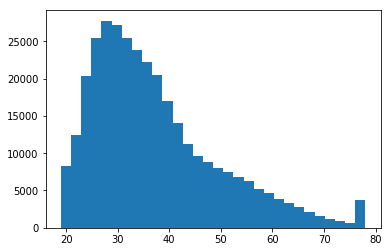

In [6]:
# La edad debería ser numerica pero tiene valores no numericos (como '\\N'). El siguiente comando arroja error:
# pagadores.edad.astype(int)

# También hay errores en los datos. Hay valores negativos y muy altos (arriba de 100). Corregir eso con
# percentiles (95 o 99)

pagadores.edad = pd.to_numeric(pagadores.edad, errors='coerce')
pagadores = acotar_columna('edad',pagadores,0.01)
plt.hist(pagadores.edad.dropna(),bins=30)
plt.show()


In [7]:
# Quitar valores erróneos de categorías

vals_ocupacion = ['E','I','O','P','S','1','2','3','4','5','6','7','8','9']
pagadores.loc[-pagadores.ocupacion.isin(vals_ocupacion),'ocupacion'] = np.nan

vals_vivienda = ['A','R','F','I','P','O']
pagadores.loc[-pagadores.tipo_vivienda.isin(vals_vivienda),'tipo_vivienda'] = np.nan

vals_academico = ['H','B','U','E','N','P','S','T','I']
pagadores.loc[-pagadores.nivel_academico.isin(vals_academico),'tipo_vivienda'] = np.nan


**genero**

| **Código** | **Descripción**           |
| ---------- |:-------------------------:|
| F          | FEMENINO                  |
| M          | MASCULINO                 |


In [8]:
print(pagadores.genero.value_counts(dropna=False))

F      169336
M      163561
NaN      5709
Name: genero, dtype: int64


**ocupacion**

| **Código** | **Descripción**           |
| ---------- |:-------------------------:|
| E          | SOCIO O EMPLEADO - SOCIO  |    		
| I          | DESEMPLEADO CON INGRESOS  |    		
| O          | OTRA                      |
| P          | INDEPENDIENTE             |          		
| S          | DESEMPLEADO SIN INGRESOS  |  		
| 1          | EMPLEADO                  |  		
| 2          | ESTUDIANTE                |  		
| 3          | INDEPENDIENTE             | 		
| 4          | HOGAR               		 |
| 5          | JUBILADO                  |  		
| 6          | AGRICULTOR                |  		
| 7          | GANADERO                  |  		
| 8          | COMERCIANTE               |  		
| 9          | RENTISTA DE CAPITAL       |

Si en los datos aparece algún otro código no listado en la tabla anterior, es posible asumir que se trata de un valor nulo, no disponible para el cliente en cuestión.


In [9]:
print(pagadores.ocupacion.value_counts(dropna=False))

1      210488
3       31971
2       31166
P       17770
5        9984
E        9042
NaN      6837
8        6154
4        5915
O        3955
9        2296
S        1364
I        1081
7         324
6         259
Name: ocupacion, dtype: int64


**tipo_vivienda**

| **Código** | **Descripción**           |
| ---------- |:-------------------------:|
| A          | ALQUILADA                 |
| R          | ALQUILADA                 |
| F          | FAMILIAR                  |
| I          | NO INFORMA                |
| P          | PROPIA                    |
| O          | PROPIA                    |

Si en los datos aparece algún otro código no listado en la tabla anterior, es posible asumir que se trata de un valor nulo, no disponible para el cliente en cuestión.

In [10]:
print(pagadores.tipo_vivienda.value_counts(dropna=False))

NaN    172315
F       83718
O       44668
R       25764
I       12141
Name: tipo_vivienda, dtype: int64


**nivel_academico**

| **Código** | **Descripción**           |
| ---------- |:-------------------------:|
| H          | BACHILLERATO              |
| B          | BACHILLERATO              |
| U          | UNIVERSITARIO             |
| E          | ESPECIALIZACION           |
| N          | NINGUNO                   |
| P          | PRIMARIA                  |
| S          | POSTGRADO                 |
| T          | TECNICO                   |
| I          | NO INFORMA                |

In [11]:
print(pagadores.nivel_academico.value_counts(dropna=False))

# Se unen los dos valores de esta variable que corresponden a "BACHILLERATO"
pagadores.nivel_academico[pagadores.nivel_academico == 'H'] = 'B'

U      135754
I       49357
T       45266
NaN     44293
H       24421
S       19614
E        8754
B        4820
N        3464
P        2863
Name: nivel_academico, dtype: int64


C:\Users\edescobar\AppData\Local\Continuum\miniconda3\envs\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**estado_civil**

| **Código** | **Descripción**           |
| ---------- |:-------------------------:|
| S          | SOLTERO                   |
| M          | CASADO                    |
| F          | DESCONOCIDO               |
| I          | NO INFORMA                |
| D          | DIVORCIADO                |
| W          | VIUDO                     |
| O          | OTRO                      |


In [12]:
print(pagadores.estado_civil.value_counts(dropna=False))

S      175878
M       79954
F       31984
I       26682
D       12057
NaN      6600
W        3357
O        2094
Name: estado_civil, dtype: int64


**ingreso_rango y seg_str**

In [13]:
print(pagadores.ingreso_rango.value_counts(dropna=False))

print(pagadores.seg_str.value_counts())

b. (1.1  2.2MM]    105099
c. (2.2  3.3MM]     54872
a. (0  1.1MM]       44310
i. (8.7  Inf)       39249
d. (3.3  4.4MM]     34922
e. (4.4  5.5MM]     20189
f. (5.5  6.6MM]     14145
g. (6.6  7.6MM]     10628
h. (7.6  8.7MM]      7808
No disponible        6271
0                    1113
Name: ingreso_rango, dtype: int64
PERSONAL         233568
PERSONAL PLUS     45392
EMPRENDEDOR       40718
PREFERENCIAL      18501
OTRO                427
Name: seg_str, dtype: int64


## 2. Procesamiento de tabla *dt_trxpse_personas_2016_2018_muestra_adjt*

* Tabla con transacciones PSE durante 2016-09 a 2018-10 (muestra aleatoria de clientes persona -- 340 mil clientes --)

| **Campo**     | **Descripción**                    | **Tipo**       |
| ------------- |:----------------------------------:|:--------------:|
| id_trn_ach    | identificador único de transacción | string         |
| id_cliente    | id. único de cliente (pagador)     | bigint         |
| fecha         | fecha de transacción               | decimal(8,0)   |
| hora          | hora de transacción (HHMMSS)       | decimal(6,0)   |
| valor_trx     | valor ($) transacción              | double         |
| ref1          | texto libre referencia 1           | string         |
| ref2          | texto libre referencia 2           | string         |
| ref3          | texto libre referencia 3           | string         |
| sector        | sector eco. receptor               | varchar(24)    |
| subsector     | subsector eco. receptor            | varchar(62)    |
| descripcion   | descripción subsector receptor     | varchar(24)    |

In [2]:
# Tabla con los nombres de las columnas de la tabla de pagadores
metadata_tr = pd.read_excel('Metadatos_Tabla personas.xlsx')
metadata_tr

,name,type,comment
0,id_trn_ach,string,NaN
1,id_cliente,bigint,NaN
2,fecha,"decimal(8,0)",NaN
3,hora,"decimal(6,0)",NaN
4,valor_trx,double,NaN
5,ref1,string,NaN
6,ref2,string,NaN
7,ref3,string,NaN
8,sector,varchar(24),NaN
9,subsector,varchar(62),NaN


In [3]:
# Se carga la tabla de personas y se visualizan sus primeras filas
# IMPORTANTE: poner "quoting=3" para no tener problema con algunas comillas
personas = pd.read_csv('dt_trxpse_personas_2016_2018_muestra_adjt.csv',names=metadata_tr.name,quoting=3)
personas.head(10)

,id_trn_ach,id_cliente,fecha,hora,valor_trx,ref1,ref2,ref3,sector,subsector,descripcion
0,230435642,3,20161207.0,113451,2122392.51,CC,NaN,NaN,\N,\N,\N
1,222356110,10,20161016.0,3424,148438.37,Referencia: Contrato: Valor:,CC,NaN,\N,\N,\N
2,309137749,10,20180120.0,195042,94025.19,CC,NaN,NaN,\N,\N,\N
3,324614737,10,20180326.0,192146,94430.07000000001,CC,NaN,NaN,\N,\N,\N
4,235344690,18,20170106.0,201317,670645.5699999999,MEDICINA PREPAGADA COLSANITAS,CE,NaN,\N,\N,\N
5,320049316,18,20180307.0,143513,706933.7,RECAUDO COLSANITAS,CC,NaN,\N,\N,\N
6,230519178,19,20161207.0,155840,306773.79,CC,NaN,NaN,\N,\N,\N
7,241307506,19,20170210.0,142809,701067.98,Pago de la Planilla Cesantias,CEDULA DE CIUDADANIA,NaN,SERVICIOS FINANCIEROS,OTROS SERVICIOS FINANCIEROS,Otras actividades auxiliares de las actividade...
8,316193109,24,20180220.0,153148,767571.01,CC,NaN,NaN,\N,\N,\N
9,282076350,26,20170914.0,70026,100277.45,Pago de la factura # CONJUNTO RESIDENCIAL PIET...,IDC,NaN,\N,\N,\N


In [12]:
# Información sobre dimensiones y tipos de datos de la tabla
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11866506 entries, 0 to 11866505
Data columns (total 11 columns):
id_trn_ach     object
id_cliente     object
fecha          float64
hora           object
valor_trx      object
ref1           object
ref2           object
ref3           float64
sector         object
subsector      object
descripcion    object
dtypes: float64(2), object(9)
memory usage: 995.9+ MB


Cota inferior: 3097.6681, Cota superior: 3851900.4455999946


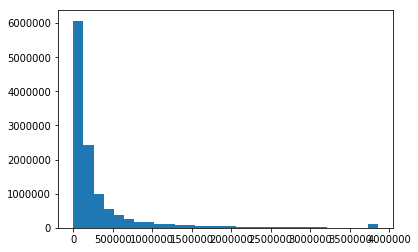

In [15]:
# Los registros de texto que tienen como valor '\N' se cambian a NA
personas.loc[personas.descripcion==r'\N','descripcion'] = np.nan
personas.loc[personas.sector==r'\N','sector'] = np.nan
personas.loc[personas.subsector==r'\N','subsector'] = np.nan

# Se acota la columna del valor de transacciones
personas.valor_trx = pd.to_numeric(personas.valor_trx, errors='coerce')
personas = acotar_columna('valor_trx',personas,0.01)
plt.hist(personas.valor_trx.dropna(),bins=30)
plt.show()


In [1]:
# Se quita la columna ref3 y las filas que tengan NA en ['fecha','hora','sector','subsector','descripcion']

print('Dimensiones originales de la base: {}'.format(personas.shape))
print('Porcentaje de missing de las variables:')
print(personas.isnull().sum()/len(personas))

personas = personas.drop('ref3', 1)
personas = personas.dropna(subset=['fecha','hora','sector','subsector','descripcion']).copy()

print('Nuevas dimensiones de la base: {}'.format(personas.shape))
print('Porcentaje de missing de las variables:')
print(personas.isnull().sum()/len(personas))


NameError: name 'personas' is not defined

In [17]:
# Procesamiento de la columna "fecha"

personas.fecha = personas.fecha.astype(int)
personas['hora_fix'] = np.where(personas.hora.str.len()==6,personas.hora.str.slice(0,2),personas.hora.str.slice(0,1))
personas.hora_fix = [i.zfill(2) for i in personas.hora_fix]

personas['date'] = personas.fecha.astype(str)+ ',' + personas.hora_fix
personas['date'] = [datetime.strptime(i, '%Y%m%d,%H') for i in personas.date]

personas = personas.drop(['fecha','hora','hora_fix'], 1)
# Dia de la semana en el que ocurre la transacción
personas['dia_trx'] = [i.day_name() for i in personas['date']]

## 3. Visualizar de nuevo y guardar las dos tablas después de los cambios

In [18]:
personas.head()

,id_trn_ach,id_cliente,valor_trx,ref1,ref2,sector,subsector,descripcion,date,dia_trx
7,241307506,19,701067.98,Pago de la Planilla Cesantias,CEDULA DE CIUDADANIA,SERVICIOS FINANCIEROS,OTROS SERVICIOS FINANCIEROS,Otras actividades auxiliares de las actividade...,2017-02-10 14:00:00,Friday
16,359125394,35,246964.14,CPV,NaN,SERVICIOS FINANCIEROS,BANCOS,Bancos comerciales,2018-08-08 12:00:00,Wednesday
18,285847659,40,192491.73,Pago Factura Asociado,BancoomevaPFA,SERVICIOS FINANCIEROS,BANCOS,Bancos comerciales,2017-10-03 15:00:00,Tuesday
22,319249942,45,49520.98,Presentación y Pago del Impuesto Predial Unifi...,AAAXDFT null,GOBIERNO,MUNICIPIOS,Actividades ejecutivas de la administración pú...,2018-03-05 11:00:00,Monday
23,335337578,45,431146.54,EDIF MIRABELL PH BOG,NaN,SERVICIOS FINANCIEROS,BANCOS,Bancos comerciales,2018-05-07 14:00:00,Monday


In [24]:
pagadores.head()

,id_cliente,seg_str,ocupacion,tipo_vivienda,nivel_academico,estado_civil,genero,edad,ingreso_rango
0,18,PERSONAL PLUS,5,O,U,M,M,78.0,e. (4.4 5.5MM]
1,32,PERSONAL PLUS,E,F,T,M,M,78.0,i. (8.7 Inf)
2,41,EMPRENDEDOR,3,O,I,W,M,78.0,b. (1.1 2.2MM]
3,47,EMPRENDEDOR,7,NaN,I,I,M,78.0,c. (2.2 3.3MM]
4,71,PERSONAL,5,O,S,M,M,78.0,e. (4.4 5.5MM]


In [22]:
# Guardar las bases

pagadores.to_csv('pagadores_procesada.csv',index=False)
personas.to_csv('personas_procesada.csv',index=False)
